
#  Diabetes Classification Pipeline 



##  Imports libraries

In [1]:

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datasets import load_dataset

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression




##  Load & Inspect the Dataset

In [2]:

print("Loading dataset from Hugging Face (weeebdev/diabetes)...")
df= load_dataset("weeebdev/diabetes")
df = df['train'].to_pandas().copy()



Loading dataset from Hugging Face (weeebdev/diabetes)...


In [3]:
print(df.shape)

(768, 9)


In [4]:
df.head()

,Number of times pregnant,Plasma glucose concentration a 2 hours in an oral glucose tolerance test,Diastolic blood pressure (mm Hg),Triceps skin fold thickness (mm),2-Hour serum insulin (mu U/ml),Body mass index (weight in kg/(height in m)^2),Diabetes pedigree function,Age (years),Class variable
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                                                                    Non-Null Count  Dtype  
---  ------                                                                    --------------  -----  
 0   Number of times pregnant                                                  768 non-null    int64  
 1   Plasma glucose concentration a 2 hours in an oral glucose tolerance test  768 non-null    int64  
 2   Diastolic blood pressure (mm Hg)                                          768 non-null    int64  
 3   Triceps skin fold thickness (mm)                                          768 non-null    int64  
 4   2-Hour serum insulin (mu U/ml)                                            768 non-null    int64  
 5   Body mass index (weight in kg/(height in m)^2)                            768 non-null    float64
 6   Diabetes pedigree function                                         


##  Handle Missing Values or Incorrect Data Types 



In [6]:
df.isna().sum()

Number of times pregnant                                                    0
Plasma glucose concentration a 2 hours in an oral glucose tolerance test    0
Diastolic blood pressure (mm Hg)                                            0
Triceps skin fold thickness (mm)                                            0
2-Hour serum insulin (mu U/ml)                                              0
Body mass index (weight in kg/(height in m)^2)                              0
Diabetes pedigree function                                                  0
Age (years)                                                                 0
Class variable                                                              0
dtype: int64

In [7]:
df.dtypes

Number of times pregnant                                                      int64
Plasma glucose concentration a 2 hours in an oral glucose tolerance test      int64
Diastolic blood pressure (mm Hg)                                              int64
Triceps skin fold thickness (mm)                                              int64
2-Hour serum insulin (mu U/ml)                                                int64
Body mass index (weight in kg/(height in m)^2)                              float64
Diabetes pedigree function                                                  float64
Age (years)                                                                   int64
Class variable                                                                int64
dtype: object

In [8]:
df.duplicated().sum()

np.int64(0)

In [9]:
zero_ratio = (df.select_dtypes(include="number") == 0).mean().sort_values()
print(zero_ratio.head(10)*100)


Diabetes pedigree function                                                   0.000000
Age (years)                                                                  0.000000
Plasma glucose concentration a 2 hours in an oral glucose tolerance test     0.651042
Body mass index (weight in kg/(height in m)^2)                               1.432292
Diastolic blood pressure (mm Hg)                                             4.557292
Number of times pregnant                                                    14.453125
Triceps skin fold thickness (mm)                                            29.557292
2-Hour serum insulin (mu U/ml)                                              48.697917
Class variable                                                              65.104167
dtype: float64


In [10]:
zero_count = (df.select_dtypes(include="number") == 0).sum().sort_values()
print(zero_count)


Diabetes pedigree function                                                    0
Age (years)                                                                   0
Plasma glucose concentration a 2 hours in an oral glucose tolerance test      5
Body mass index (weight in kg/(height in m)^2)                               11
Diastolic blood pressure (mm Hg)                                             35
Number of times pregnant                                                    111
Triceps skin fold thickness (mm)                                            227
2-Hour serum insulin (mu U/ml)                                              374
Class variable                                                              500
dtype: int64


In [11]:

invalid_zero_cols = [
    "Plasma glucose concentration a 2 hours in an oral glucose tolerance test",
    "Diastolic blood pressure (mm Hg)",
    "Triceps skin fold thickness (mm)",
    "2-Hour serum insulin (mu U/ml)",
    "Body mass index (weight in kg/(height in m)^2)",
]

df[invalid_zero_cols] = (
    df[invalid_zero_cols]
    .replace(0, np.nan)
    .fillna(df[invalid_zero_cols].median())
)


In [12]:
zero_ratio = (df.select_dtypes(include="number") == 0).mean().sort_values()
print(zero_ratio.head(10)*100)


Plasma glucose concentration a 2 hours in an oral glucose tolerance test     0.000000
Diastolic blood pressure (mm Hg)                                             0.000000
Triceps skin fold thickness (mm)                                             0.000000
2-Hour serum insulin (mu U/ml)                                               0.000000
Diabetes pedigree function                                                   0.000000
Body mass index (weight in kg/(height in m)^2)                               0.000000
Age (years)                                                                  0.000000
Number of times pregnant                                                    14.453125
Class variable                                                              65.104167
dtype: float64


## Encode Target 

the target not need encoding

In [13]:
print(df['Class variable'].unique())
print(df['Class variable'].value_counts())


[1 0]
Class variable
0    500
1    268
Name: count, dtype: int64


In [14]:
target_col = 'Class variable'


##  Train / Validation / Test Split

In [15]:
X = df.drop(columns=[target_col])
y = df[target_col]


In [16]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

##  K-Fold Cross-Validation 

In [17]:

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("Using StratifiedKFold with n_splits=5")


Using StratifiedKFold with n_splits=5


## Hyperparameter Tuning for each model

In [18]:
best_models = {}

## SVM

In [19]:
svm_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SVC())
])

svm_grid = {
    'clf__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'clf__C': [0.1, 1, 10]
}

svm_gs = GridSearchCV(svm_pipe, svm_grid, cv=skf, scoring='f1', n_jobs=-1)
svm_gs.fit(X_train, y_train)

print("SVM  Best Params:", svm_gs.best_params_)
print("SVM  Best CV F1 :", round(svm_gs.best_score_, 4))

best_models['SVM'] = svm_gs.best_estimator_


SVM  Best Params: {'clf__C': 1, 'clf__kernel': 'linear'}
SVM  Best CV F1 : 0.6442


## Decision Tree

In [20]:
dt_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', DecisionTreeClassifier(random_state=42))
])

dt_grid = {
    'clf__max_depth': [None, 5, 10]
}

dt_gs = GridSearchCV(dt_pipe, dt_grid, cv=skf, scoring='f1', n_jobs=-1)
dt_gs.fit(X_train, y_train)

print("DT   Best Params:", dt_gs.best_params_)
print("DT   Best CV F1 :", round(dt_gs.best_score_, 4))

best_models['Decision Tree'] = dt_gs.best_estimator_


DT   Best Params: {'clf__max_depth': 5}
DT   Best CV F1 : 0.5692


## Random Forest

In [21]:
rf_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(random_state=42))
])

rf_grid = {
    'clf__n_estimators': [100, 300]
}

rf_gs = GridSearchCV(rf_pipe, rf_grid, cv=skf, scoring='f1', n_jobs=-1)
rf_gs.fit(X_train, y_train)

print("RF   Best Params:", rf_gs.best_params_)
print("RF   Best CV F1 :", round(rf_gs.best_score_, 4))

best_models['Random Forest'] = rf_gs.best_estimator_


RF   Best Params: {'clf__n_estimators': 100}
RF   Best CV F1 : 0.6467


## k-NN

In [22]:
knn_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', KNeighborsClassifier())
])

knn_grid = {
    'clf__n_neighbors': [3, 5, 11]
}

knn_gs = GridSearchCV(knn_pipe, knn_grid, cv=skf, scoring='f1', n_jobs=-1)
knn_gs.fit(X_train, y_train)

print("kNN  Best Params:", knn_gs.best_params_)
print("kNN  Best CV F1 :", round(knn_gs.best_score_, 4))

best_models['k-NN'] = knn_gs.best_estimator_


kNN  Best Params: {'clf__n_neighbors': 11}
kNN  Best CV F1 : 0.6405


## Logistic Regression

In [23]:
logreg_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000, solver='lbfgs'))
])

logreg_grid = {
    'clf__C': [0.1, 1, 10]
}

logreg_gs = GridSearchCV(logreg_pipe, logreg_grid, cv=skf, scoring='f1', n_jobs=-1)
logreg_gs.fit(X_train, y_train)

print("LR   Best Params:", logreg_gs.best_params_)
print("LR   Best CV F1 :", round(logreg_gs.best_score_, 4))

best_models['Logistic Regression'] = logreg_gs.best_estimator_


LR   Best Params: {'clf__C': 1}
LR   Best CV F1 : 0.6523


## XGBoost

In [24]:
from xgboost import XGBClassifier

xgb_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', XGBClassifier(random_state=42, eval_metric='logloss'))
])

xgb_grid = {
    'clf__n_estimators': [100, 300],
    'clf__max_depth': [3, 5]
}

xgb_gs = GridSearchCV(
    xgb_pipe,
    xgb_grid,
    cv=skf,
    scoring='f1',
    n_jobs=-1
)

xgb_gs.fit(X_train, y_train)

print("XGB  Best Params:", xgb_gs.best_params_)
print("XGB  Best CV F1 :", round(xgb_gs.best_score_, 4))

best_models['XGBoost'] = xgb_gs.best_estimator_


XGB  Best Params: {'clf__max_depth': 3, 'clf__n_estimators': 100}
XGB  Best CV F1 : 0.5933


## Model Training

In [25]:
X_trfinal = pd.concat([X_train, X_valid], axis=0)
y_trfinal = pd.concat([y_train, y_valid], axis=0)

required = ["SVM", "Decision Tree", "Random Forest", "XGBoost", "k-NN", "Logistic Regression"]

trained_models = {}
for name in required:
    model = best_models[name]           
    model.fit(X_trfinal, y_trfinal)     
    trained_models[name] = model
    print(f"✔ Trained: {name}")


✔ Trained: SVM
✔ Trained: Decision Tree
✔ Trained: Random Forest
✔ Trained: XGBoost
✔ Trained: k-NN
✔ Trained: Logistic Regression


## Evaluation & Comparison

In [26]:


results = []
cms = {}

for name, model in trained_models.items():
    preds = model.predict(X_test)
    acc  = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds, zero_division=0)
    rec  = recall_score(y_test, preds, zero_division=0)
    f1   = f1_score(y_test, preds, zero_division=0)
    cm   = confusion_matrix(y_test, preds)

    results.append({"Model": name, "Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1})
    cms[name] = cm

summary = pd.DataFrame(results).sort_values(by="F1", ascending=False).reset_index(drop=True)
summary


,Model,Accuracy,Precision,Recall,F1
0,XGBoost,0.775862,0.741935,0.560976,0.638889
1,Decision Tree,0.784483,0.807692,0.512195,0.626866
2,Random Forest,0.758621,0.740741,0.487805,0.588235
3,k-NN,0.724138,0.645161,0.487805,0.555556
4,SVM,0.741379,0.720000,0.439024,0.545455
5,Logistic Regression,0.724138,0.680000,0.414634,0.515152


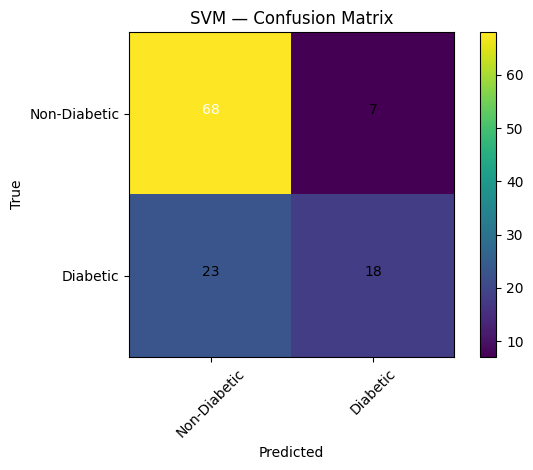

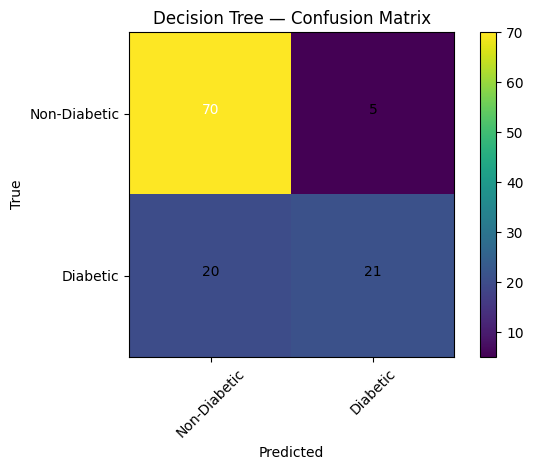

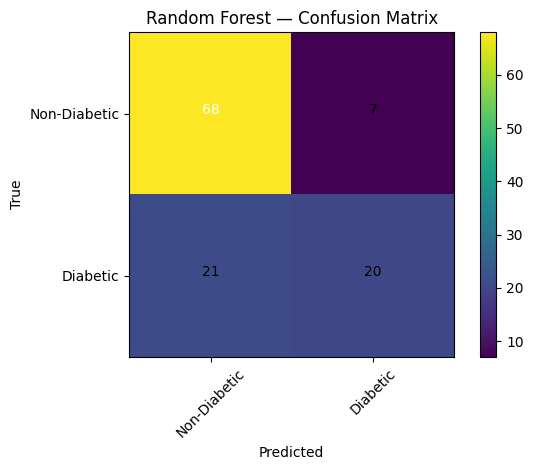

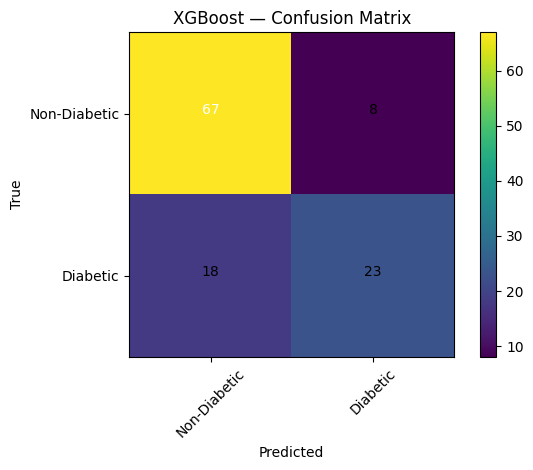

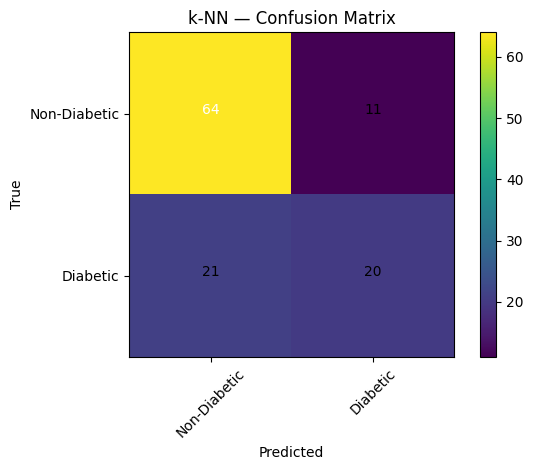

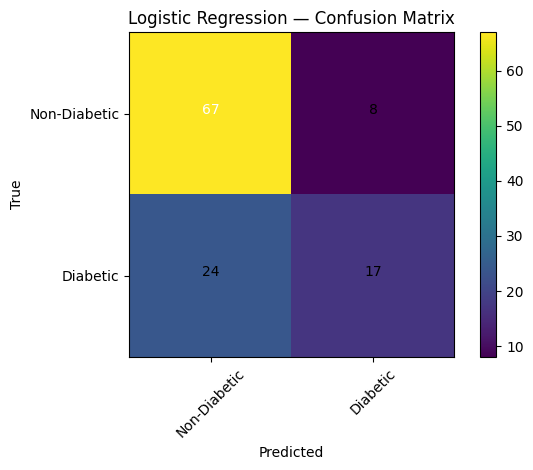

In [27]:


for name, cm in cms.items():
    plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title(f"{name} — Confusion Matrix")
    plt.colorbar()
    ticks = np.arange(2)
    plt.xticks(ticks, ['Non-Diabetic','Diabetic'], rotation=45)
    plt.yticks(ticks, ['Non-Diabetic','Diabetic'])

    thresh = cm.max()/2 if cm.max()!=0 else 0.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, int(cm[i, j]),
                     ha="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()


## Conclusions

- **XGBoost** delivered the best overall balance with the highest **F1 = 0.639** and **Recall = 0.561**, and near-top **Accuracy = 0.776**.  
- **Decision Tree** achieved the top **Accuracy = 0.784** and **Precision = 0.808**, with **F1 = 0.627** (lower recall than XGBoost).  
- **Random Forest** ranked third overall (**F1 = 0.588**, **Accuracy = 0.759**) and showed reasonable balance.  
- **k-NN** and **SVM** had lower **F1** scores (**0.556** and **0.545**, respectively) than tree-based models; **Logistic Regression** was the lowest (**F1 = 0.515**).  
- **Overall:** tree-based methods (**XGBoost**, **Decision Tree**, **Random Forest**) outperformed other classifiers on this task. Choose **XGBoost** if you prioritize balanced F1/recall, or **Decision Tree** if you value accuracy/precision and interpretability.
